In [60]:
import numpy as np
from math import factorial as fact
import copy
import progressbar

class Bose:
    
    # Начальные данные
    def __init__(self, m, n, n_max=None):
        '''m - число узлов, n - число частиц, n_max - максимальное число частиц на узле.'''
        self.m = m
        self.n = n
        self.n_max = n_max
    
    # Базис
    def basis(self):
        '''Возвращает базис для Бозе-статистики. m - число узлов, n - число частиц'''
        R = fact(self.n + self.m - 1)/fact(self.n)/fact(self.m - 1)
        b = np.zeros((R,self.m))
        b[0,self.m-1] = self.n
        for i in range(R-1):
            j = self.m - 1
            while j > 0:
                if b[i,j] in range(2,self.n+1) :
                    b[i+1,:] = b[i,:]
                    b[i+1,j] = 0
                    b[i+1,j-1] = b[i+1,j-1] + 1
                    b[i+1,self.m-1] = b[i,j] - 1
                    break
                elif b[i,j] > 0:
                    b[i+1,:] = b[i,:]
                    b[i+1,j-1] = b[i+1,j-1] + 1
                    b[i+1,j] = b[i,j] - 1
                    break
                j -= 1
        return b
        
    def limit_basis(self):
        '''Возвращает базис для Бозе-статистики с ограничением числа частиц на узле.'''
        R = fact(self.n + self.m - 1)/fact(self.n)/fact(self.m - 1)
        b = self.basis()
        f = np.zeros((R,self.m))
        j = 0
        # Откиддываем функции, в которых на узлах частиц больше n_max
        for i in range(b.shape[0]):
            if any(b[i] > self.n_max): 
                continue
            else:
                f[j] = b[i]
                j += 1
        return f[:j]
    
    # Построение Гамильтоновой матрицы
    def up_down(self, number_to_up, number_to_down, func):
        '''Функция возвращает коэффициент и новую функцию.'''
        function = copy.copy(func)
        if function[number_to_down] == 0:
            return [0,function]
        elif function[number_to_up] == self.n_max:
            return [0,function]
        else:
            coef_down = np.sqrt(function[number_to_down])
            function[number_to_down] = function[number_to_down] - 1
            coef_up = np.sqrt(function[number_to_up] + 1)
            function[number_to_up] = function[number_to_up] + 1
        return [round(coef_down*coef_up,5), function]
    def h_block(self,V=1):
        ''' Функция заполняет блоки матрицы Гамильтона.'''
        fi = self.limit_basis()    
        # Переводим тип матрицы в целочисленную для корректной работы метода ''.join(...)
        fi = fi.astype(int)

        H = np.zeros((len(fi),len(fi)))
        # Создаем словарь для определения индекса функции 
        key = [''.join(map(str,fi[i])) for i in range(fi.shape[0])]
        value = range(len(key))
        indexes = dict(zip(key,value))


        for i in range(len(fi)):
            for j in range(1,self.m,1):
                # Перескоки с ванны на узел и обратно
                H[i,indexes[''.join(map(str,self.up_down(0,j,fi[i])[1]))]] += V*self.up_down(0,j,fi[i])[0]
                H[i,indexes[''.join(map(str,self.up_down(j,0,fi[i])[1]))]] += V*self.up_down(j,0,fi[i])[0]
        return H, len(fi)
    def hamiltonian(self):
        '''Функция соединяет блоки в одну матрицу.'''
        R1 = 0
        H = np.zeros(((self.n_max+1)**self.m,(self.n_max+1)**self.m))
        bar = progressbar.ProgressBar()
        runs = self.n
        for n_current in bar(range(runs)):
            self.n = n_current
            h, R2 = self.h_block()
            H[R1:(R1+R2), R1:(R2+R1)] = h
            R1 += R2
        return H

class Fermi(Bose):
    def __init__(self, m, n, n_down, n_max=1):
        Bose.__init__(self,m,n,n_max)
        self.n_down = n_down
    
    def __str__(self):
        return  '[Fermi particle: m = {0}, n_up = {1}, n_down = {2}, n_max = {3}]'.format(self.m, self.n, self.n_down, self.n_max)
    
    def basis_spin(self):
        '''Возвращает базис для Ферми-статистики с учетом спина.'''
        initial_n = self.n
        R = (fact(self.m)/fact(self.n)/fact(self.m-self.n))*(fact(self.m)/fact(self.n_down)/fact(self.m-self.n_down)) 
        fs = np.zeros((R,2*self.m))
        part_1 = self.limit_basis()
        if self.n == self.n_down:
            part_2 = copy.copy(part_1)
        else:
            self.n = self.n_down
            part_2 = self.limit_basis()
        for i in range(part_1.shape[0]):
            for j in range(part_2.shape[0]):
                fs[i*part_2.shape[0]+j] = np.concatenate((part_1[i],part_2[j]), axis=0)
        self.n = initial_n
        return fs
    
    def sign(self,k,l,m,func):
        '''Функция определяет знак перескока'''
        if k > (m-1):
            (k,l) = (k-m,l-m)
        if sum(func[k+1:l])%2:
            return 1
        else:
            return -1
    
    def hamiltonian(self,U,V,ee):
        '''Возвращает гамильтонову матрицу.
        U - взаимодействие на узле, V - величина перескока, ee - затравочная энергия, 
        V и ee задаются массивом длинной 2*(m-1) и (m-1) соответственно.'''
        fi = self.basis_spin()
        # Переводим тип матрицы в целочисленную для корректной работы метода ''.join(...)
        fi = fi.astype(int)
        H = np.zeros((len(fi),len(fi)))

        # Создаем словарь для определения индекса функции 
        key = [''.join(map(str,fi[i])) for i in range(fi.shape[0])]
        value = range(len(key))
        indexes = dict(zip(key,value))

        bar = progressbar.ProgressBar()
        for i in bar(range(len(fi))):
            for j in range(1,self.m):
                # Перескоки с ванны на узел и обратно
                H[i,indexes[''.join(map(str,self.up_down(0,j,fi[i])[1]))]] += V[j-1]*self.sign(0,j,self.m,fi[i])*self.up_down(0,j,fi[i])[0]
                H[i,indexes[''.join(map(str,self.up_down(self.m,j+self.m,fi[i])[1]))]] += V[j+self.m-2]*self.sign(self.m,j+self.m,self.m,fi[i])*self.up_down(self.m,j+self.m,fi[i])[0]
                H[i,indexes[''.join(map(str,self.up_down(j,0,fi[i])[1]))]] += V[j-1]*self.sign(0,j,self.m,fi[i])*self.up_down(j,0,fi[i])[0]
                H[i,indexes[''.join(map(str,self.up_down(j+self.m,self.m,fi[i])[1]))]] += V[j+self.m-2]*self.sign(self.m,j+self.m,self.m,fi[i])*self.up_down(j+self.m,self.m,fi[i])[0]
                H[i,i] += ee[j-1] * (fi[i][j] + fi[i][j+self.m])

            # One-site interactive
            H[i,i] += U * fi[i][0]*fi[i][self.m]
        return H


In [61]:
help(Bose)

Help on class Bose in module __main__:

class Bose
 |  Methods defined here:
 |  
 |  __init__(self, m, n, n_max=None)
 |      m - число узлов, n - число частиц, n_max - максимальное число частиц на узле.
 |  
 |  basis(self)
 |      Возвращает базис для Бозе-статистики. m - число узлов, n - число частиц
 |  
 |  h_block(self, V=1)
 |      Функция заполняет блоки матрицы Гамильтона.
 |  
 |  hamiltonian(self)
 |      Функция соединяет блоки в одну матрицу.
 |  
 |  limit_basis(self)
 |      Возвращает базис для Бозе-статистики с ограничением числа частиц на узле.
 |  
 |  up_down(self, number_to_up, number_to_down, func)
 |      Функция возвращает коэффициент и новую функцию.



In [62]:
help(Fermi)

Help on class Fermi in module __main__:

class Fermi(Bose)
 |  Methods defined here:
 |  
 |  __init__(self, m, n, n_down, n_max=1)
 |  
 |  __str__(self)
 |  
 |  basis_spin(self)
 |      Возвращает базис для Ферми-статистики с учетом спина.
 |  
 |  hamiltonian(self, U, V, ee)
 |      Возвращает гамильтонову матрицу.
 |      U - взаимодействие на узле, V - величина перескока, ee - затравочная энергия, 
 |      V и ee задаются массивом длинной 2*(m-1) и (m-1) соответственно.
 |  
 |  sign(self, k, l, m, func)
 |      Функция определяет знак перескока
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Bose:
 |  
 |  basis(self)
 |      Возвращает базис для Бозе-статистики. m - число узлов, n - число частиц
 |  
 |  h_block(self, V=1)
 |      Функция заполняет блоки матрицы Гамильтона.
 |  
 |  limit_basis(self)
 |      Возвращает базис для Бозе-статистики с ограничением числа частиц на узле.
 |  
 |  up_down(self, number_to_up, nu

In [63]:
f = Fermi(6,3,3)
U = 4
V = np.array([1,2,1,2,1,2,1,2,1,2,1,2,1,2])
ee = np.array([-1,-2,-1,0,1,2,1])

In [64]:
f.__str__()

'[Fermi particle: m = 6, n_up = 3, n_down = 3, n_max = 1]'

In [65]:
import time
st = time.time()
G = f.hamiltonian(U,V,ee)
full_time = time.time() - st
print full_time

100% (400 of 400) |#######################| Elapsed Time: 0:00:00 Time: 0:00:00


0.667999982834


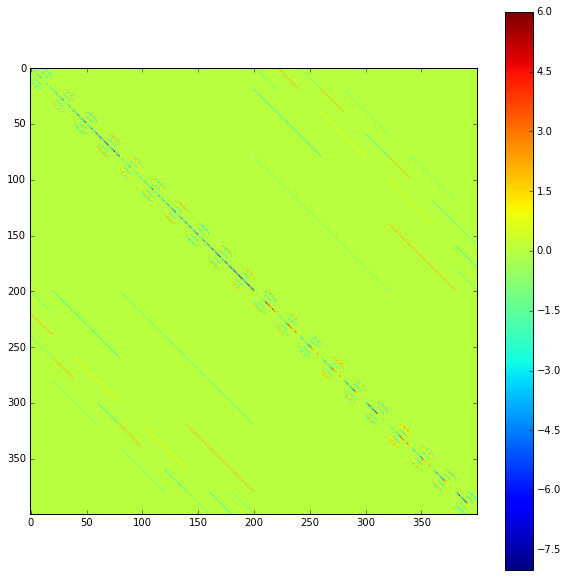

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,10))
plt.imshow(G)
plt.colorbar()

In [67]:
h1 = Bose(6,18,3)

In [68]:
H = h1.hamiltonian()

100% (18 of 18) |#########################| Elapsed Time: 0:00:02 Time: 0:00:02


In [69]:
H.shape

(4096L, 4096L)

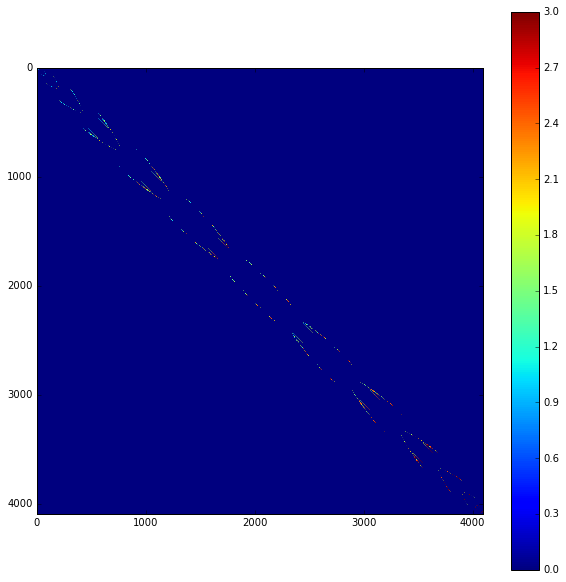

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,10))
plt.imshow(H)
plt.colorbar()